# Modeling Workbook
- duplicated notebook from Brandon to work on visualizing model performance

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from math import sqrt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import IsolationForest, RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
from prepare import handle_nulls, set_index
from preprocessing import spotify_split, split_df, scale_data, encode_features, get_top_ten_labels

In [3]:
def get_model_features(df):
    '''
    This function takes in a DataFrame and returns a DataFrame with features to use in predictive modeling.
    '''
    df = df.drop(columns=['artist', 'album', 'release_date', 'track_name'])
    return df

---
# Wrangle

In [4]:
df = pd.read_csv('full-playlist.csv', index_col=0)
df = handle_nulls(df)
df = encode_features(df)
df = get_top_ten_labels(df)
df = df.drop(columns=['track_id', 'label','track_id','album_type','album_id','album_popularity'], axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5973 entries, 0 to 5973
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            5973 non-null   object 
 1   album             5973 non-null   object 
 2   release_date      5973 non-null   object 
 3   track_name        5973 non-null   object 
 4   danceability      5973 non-null   float64
 5   energy            5973 non-null   float64
 6   key               5973 non-null   float64
 7   loudness          5973 non-null   float64
 8   mode              5973 non-null   float64
 9   speechiness       5973 non-null   float64
 10  instrumentalness  5973 non-null   float64
 11  liveness          5973 non-null   float64
 12  valence           5973 non-null   float64
 13  tempo             5973 non-null   float64
 14  duration_ms       5973 non-null   float64
 15  time_signature    5973 non-null   float64
 16  popularity        5973 non-null   float64


In [6]:
df.head()

,artist,album,release_date,track_name,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,duration_ms,time_signature,popularity,disc_number,track_number,is_explicit,top_ten_label
0,Tay-K,TRAPMAN,2020-07-12,TRAPMAN,0.792,0.594,2.0,-8.544,1.0,0.3000,...,0.244,0.351,82.512,232803.0,4.0,43.0,1.0,1.0,1,0
1,Lil Wyte,Doubt Me Now,2003-03-04,Oxy Cotton,0.816,0.578,9.0,-6.912,1.0,0.2330,...,0.114,0.265,148.077,193920.0,4.0,61.0,1.0,11.0,1,0
2,Kamelen,KINGPIN SLIM,2019-11-29,Kingpin O.G - Remix,0.649,0.798,0.0,-6.450,0.0,0.1450,...,0.409,0.717,160.011,254390.0,4.0,23.0,1.0,11.0,1,0
3,Waka Flocka Flame,Flockaveli,2010-10-01,Grove St. Party (feat. Kebo Gotti),0.705,0.702,0.0,-4.783,0.0,0.1080,...,0.364,0.771,140.059,250493.0,4.0,62.0,1.0,9.0,1,0
4,Project Pat,Mista Don't Play: Everythangs Workin',2001-02-13,Don't Save Her (feat. Crunchy Black),0.838,0.793,11.0,-5.470,0.0,0.0773,...,0.106,0.800,160.003,261933.0,4.0,45.0,1.0,5.0,1,0


In [7]:
df = get_model_features(df)

In [8]:
# split the data
X_train, y_train, X_validate, y_validate, X_test, y_test, train, validate, test = spotify_split(df, 'popularity')
X_train.head(3)

Shape of train: (4180, 16) | Shape of validate: (897, 16) | Shape of test: (896, 16)
Percent train: 70.0        | Percent validate: 15.0       | Percent test: 15.0


,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,disc_number,track_number,is_explicit,top_ten_label
3332,0.687,0.948,9.0,-3.136,0.0,0.372,0.0,0.232,0.631,119.921,148000.0,4.0,1.0,8.0,1,0
1626,0.709,0.676,9.0,-7.369,1.0,0.329,0.0,0.349,0.680,144.067,205460.0,4.0,1.0,1.0,1,0
2319,0.761,0.695,1.0,-5.395,0.0,0.192,0.0,0.318,0.547,147.979,274756.0,4.0,1.0,1.0,1,0


### Scale the Data

In [9]:
# MIN-MAX
X_train_mm, X_validate_mm, X_test_mm = scale_data(train, validate, test, 'popularity', 'MinMax')
X_train_mm.head(3)

,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,disc_number,track_number,is_explicit,top_ten_label
3332,0.696755,0.949438,0.818182,0.823952,0.0,0.387904,0.0,0.225887,0.642566,0.544474,0.245205,0.8,0.0,0.114754,1.0,0.0
1626,0.719067,0.668765,0.818182,0.660421,1.0,0.343066,0.0,0.347623,0.692464,0.654104,0.350236,0.8,0.0,0.000000,1.0,0.0
2319,0.771805,0.688371,0.090909,0.736681,0.0,0.200209,0.0,0.315368,0.557026,0.671865,0.476901,0.8,0.0,0.000000,1.0,0.0


In [10]:
# STANDARD
X_train_st, X_validate_st, X_test_st = scale_data(train, validate, test, 'popularity', 'Standard')
X_train_st.head(3)

,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,disc_number,track_number,is_explicit,top_ten_label
3332,-0.382672,1.818840,1.003165,1.348643,-1.164584,0.926952,-0.160234,0.191349,0.470375,-0.011981,-0.970947,0.029696,-0.065376,0.495387,0.480102,-0.401788
1626,-0.218486,0.069804,1.003165,-0.128026,0.858675,0.633988,-0.160234,0.921536,0.692341,0.789298,-0.031013,0.029696,-0.065376,-0.922635,0.480102,-0.401788
2319,0.169590,0.191979,-1.129438,0.560598,-1.164584,-0.299407,-0.160234,0.728067,0.089862,0.919116,1.102535,0.029696,-0.065376,-0.922635,0.480102,-0.401788


In [11]:
# ROBUST
X_train_rb, X_validate_rb, X_test_rb = scale_data(train, validate, test, 'popularity', 'Robust')
X_train_rb.head(3)

,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,disc_number,track_number,is_explicit,top_ten_label
3332,-0.382672,1.818840,1.003165,1.348643,-1.164584,0.926952,-0.160234,0.191349,0.470375,-0.011981,-0.970947,0.029696,-0.065376,0.495387,0.480102,-0.401788
1626,-0.218486,0.069804,1.003165,-0.128026,0.858675,0.633988,-0.160234,0.921536,0.692341,0.789298,-0.031013,0.029696,-0.065376,-0.922635,0.480102,-0.401788
2319,0.169590,0.191979,-1.129438,0.560598,-1.164584,-0.299407,-0.160234,0.728067,0.089862,0.919116,1.102535,0.029696,-0.065376,-0.922635,0.480102,-0.401788


--- 
# Feature Selection

In [12]:
# SELECT K BEST
from sklearn.feature_selection import SelectKBest, f_regression

In [13]:
f_selector = SelectKBest(f_regression, 5)
f_selector.fit(X_train_mm, y_train)
f_mask = f_selector.get_support()
X_train_scaled_f_reduced = X_train_mm.iloc[:,f_mask]
X_train_scaled_f_reduced.head(1)

,loudness,speechiness,track_number,is_explicit,top_ten_label
3332,0.823952,0.387904,0.114754,1.0,0.0


In [14]:
skb_features = X_train_scaled_f_reduced

In [15]:
#RFE
from sklearn.feature_selection import RFE

In [16]:
# creat3 the ML model object
lm = LinearRegression()
# create the rfe object
rfe = RFE(lm, 5)
# fit the rfe
rfe.fit(X_train_mm, y_train)
# get the feature support boolean list
rfe_mask = rfe.support_
# reduce the dataframe to just those features
X_train_scaled_rfe_reduced = X_train_mm.iloc[:,rfe_mask]
X_train_scaled_rfe_reduced.head(1)

,energy,loudness,disc_number,track_number,top_ten_label
3332,0.949438,0.823952,0.0,0.114754,0.0


In [17]:
rfe_features = X_train_scaled_rfe_reduced

--- 
# Set the baseline

In [18]:
baseline = np.mean(y_train)
baseline

38.53421052631579

In [19]:
baseline_train_rmse = round(sqrt(mean_squared_error(y_train, np.full(len(y_train), baseline))), 6)
print('RMSE (Root Mean Square Error) of Baseline on train data:\n', baseline_train_rmse)

baseline_validate_rmse = round(sqrt(mean_squared_error(y_validate, np.full(len(y_validate), baseline))), 6)
print('RMSE (Root Mean Square Error) of Baseline on validate data:\n', baseline_validate_rmse)

baseline_test_rmse = round(sqrt(mean_squared_error(y_test, np.full(len(y_test), baseline))), 6)
print('RMSE (Root Mean Square Error) of Baseline on test data:\n', baseline_test_rmse)

RMSE (Root Mean Square Error) of Baseline on train data:
 22.822029
RMSE (Root Mean Square Error) of Baseline on validate data:
 22.9586
RMSE (Root Mean Square Error) of Baseline on test data:
 23.196285


---
# MODELS

---
### Cross Validation

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
# OLS CV
params = {'fit_intercept': [True, False]}

lm = LinearRegression()

grid = GridSearchCV(lm, params, 
                    scoring= 'neg_root_mean_squared_error', 
                    cv=3, iid=True)

grid.fit(X_train_mm, y_train)

results = grid.cv_results_
#results.keys()

params = results['params']
test_scores = results['mean_test_score']

for p, s in zip(params, test_scores):
    p['RMSE'] = s

pd.DataFrame(params).sort_values(by='RMSE', ascending=False)

,fit_intercept,RMSE
0,True,-21.167502
1,False,-21.205112


In [22]:
# Lasso Lars CV
params = {'fit_intercept': [True, False],
          'alpha': [.0001, .001, .01]
         }
          
lars = LassoLars()

grid = GridSearchCV(lars, params, 
                    scoring= 'neg_root_mean_squared_error', 
                    cv=3, iid=True)

grid.fit(X_train_mm, y_train)

results = grid.cv_results_
#results.keys()

params = results['params']
test_scores = results['mean_test_score']

for p, s in zip(params, test_scores):
    p['RMSE'] = s

pd.DataFrame(params).sort_values(by='RMSE', ascending=False)

,alpha,fit_intercept,RMSE
2,0.0010,True,-21.161037
0,0.0001,True,-21.166693
4,0.0100,True,-21.194998
5,0.0100,False,-21.199645
3,0.0010,False,-21.204128
1,0.0001,False,-21.205009


In [23]:
def PolynomialRegression(degree=2, interaction_only=False, include_bias=True, order='C', **kwargs):
    from sklearn.pipeline import make_pipeline
    return make_pipeline(PolynomialFeatures(degree, interaction_only, include_bias, order),
                         LinearRegression(**kwargs))

In [24]:
PolynomialRegression().get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'polynomialfeatures', 'linearregression', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'polynomialfeatures__order', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

In [25]:
PolynomialRegression()

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [26]:
# Polynomial Features
params = {'polynomialfeatures__degree': [2, 3, 4],
          'polynomialfeatures__interaction_only': [True, False],
          'polynomialfeatures__include_bias': [True, False],
          'polynomialfeatures__order': ['C', 'F']
         }
          
pf = PolynomialRegression()

grid = GridSearchCV(pf, params, 
                    scoring= 'neg_root_mean_squared_error', 
                    cv=3, iid=True)

grid.fit(X_train_mm, y_train)

results = grid.cv_results_
#results.keys()

params = results['params']
test_scores = results['mean_test_score']

for p, s in zip(params, test_scores):
    p['RMSE'] = s

pd.DataFrame(params).sort_values(by='RMSE', ascending=False)

,polynomialfeatures__degree,polynomialfeatures__include_bias,polynomialfeatures__interaction_only,polynomialfeatures__order,RMSE
1,2,True,True,F,-2.209647e+01
0,2,True,True,C,-2.209647e+01
4,2,False,True,C,-2.209647e+01
5,2,False,True,F,-2.209647e+01
9,3,True,True,F,-3.679750e+02
13,3,False,True,F,-3.679750e+02
12,3,False,True,C,-3.679750e+02
8,3,True,True,C,-3.679750e+02
14,3,False,False,C,-4.504008e+02
10,3,True,False,C,-4.504008e+02


---
## Train and Evaluate
### OLS Model
- all features
- min-max scaler

In [27]:
lm = LinearRegression(normalize=True)
lm.fit(X_train_mm, y_train)
lm_pred = lm.predict(X_train_mm)
lm_rmse = sqrt(mean_squared_error(y_train, lm_pred))

lm_pred_v = lm.predict(X_validate_mm)
lm_rmse_v = sqrt(mean_squared_error(y_validate, lm_pred_v))

print('RMSE for OLS using Linear Regression \n')
print('On train data:\n', round(lm_rmse, 6), '\n') 
#print('On validate data:\n', round(lm_rmse_v, 6))

RMSE for OLS using Linear Regression 

On train data:
 21.065283 



### OLS Model
- select k best features (top 5)
- min-max scaler

In [28]:
lm = LinearRegression(normalize=True)
lm.fit(skb_features, y_train)
lm_pred = lm.predict(skb_features)
lm_rmse = sqrt(mean_squared_error(y_train, lm_pred))

lm_pred_v = lm.predict(X_validate_mm[skb_features.columns.to_list()])
lm_rmse_v = sqrt(mean_squared_error(y_validate, lm_pred_v))

print('RMSE for OLS using Linear Regression \n')
print('On train data:\n', round(lm_rmse, 6), '\n') 
#print('On validate data:\n', round(lm_rmse_v, 6))

RMSE for OLS using Linear Regression 

On train data:
 21.479089 



---
### OLS Model
- RFE features (top 5)
- min-max scaler

In [29]:
lm = LinearRegression(normalize=True)
lm.fit(rfe_features, y_train)
lm_pred = lm.predict(rfe_features)
lm_rmse = sqrt(mean_squared_error(y_train, lm_pred))

lm_pred_v = lm.predict(X_validate_mm[rfe_features.columns.to_list()])
lm_rmse_v = sqrt(mean_squared_error(y_validate, lm_pred_v))

print('RMSE for OLS using Linear Regression \n')
print('On train data:\n', round(lm_rmse, 6), '\n') 
#print('On validate data:\n', round(lm_rmse_v, 6))

RMSE for OLS using Linear Regression 

On train data:
 21.392088 



<div class="alert alert-block alert-info">
    <b>Takeaways</b>: using the feature selectors (opposed to using all features) and selecting the top 5 features doesn't improve model performance.</div>

### Lasso + Lars
- all features
- min-max-scaler
- alpha=0.1

In [30]:
lars = LassoLars(alpha=.001)
lars.fit(X_train_mm, y_train)

lars_pred = lars.predict(X_train_mm)
lars_rmse = sqrt(mean_squared_error(y_train, lars_pred))

lars_pred_v = lars.predict(X_validate_mm)
lars_rmse_v = sqrt(mean_squared_error(y_validate, lars_pred_v))

print('RMSE for LASSO + LARS \n')
print('On train data:\n', round(lars_rmse, 6), '\n') 
#print('On validate data:\n', round(lars_rmse_v, 6))

RMSE for LASSO + LARS 

On train data:
 21.066942 



In [31]:
# smaller alpha
lars = LassoLars(alpha=.00001, fit_intercept=False)
lars.fit(X_train_mm, y_train)

lars_pred = lars.predict(X_train_mm)
lars_rmse = sqrt(mean_squared_error(y_train, lars_pred))

lars_pred_v = lars.predict(X_validate_mm)
lars_rmse_v = sqrt(mean_squared_error(y_validate, lars_pred_v))

lars_pred_t = lars.predict(X_test_mm)###
lars_rmse_t = sqrt(mean_squared_error(y_test, lars_pred_t))###

print('RMSE for LASSO + LARS \n')
print('On train data:\n', round(lars_rmse, 6), '\n') 
#print('On validate data:\n', round(lars_rmse_v, 6))

RMSE for LASSO + LARS 

On train data:
 21.104996 



### Polynomial Features + Linear Regression

In [32]:
#squared
pf = PolynomialFeatures(degree=2)
X_train_sq = pf.fit_transform(X_train_mm)
X_validate_sq = pf.transform(X_validate_mm)

lm_sq = LinearRegression()
lm_sq.fit(X_train_sq, y_train)

lm_sq_pred = lm_sq.predict(X_train_sq)
lm_sq_rmse = sqrt(mean_squared_error(y_train, lm_sq_pred))

lm_sq_pred_v = lm_sq.predict(X_validate_sq)
lm_sq_rmse_v = sqrt(mean_squared_error(y_validate, lm_sq_pred_v))

print('RMSE for Polynomial Squared + Linear Regression \n')
print('On train data:\n', round(lm_sq_rmse, 6), '\n') 
#print('On validate data:\n', round(lm_sq_rmse_v, 6))

RMSE for Polynomial Squared + Linear Regression 

On train data:
 20.526966 



In [33]:
# cubed
pf = PolynomialFeatures(degree=3)
X_train_cb = pf.fit_transform(X_train_mm)
X_validate_cb = pf.transform(X_validate_mm)

lm_cb = LinearRegression()
lm_cb.fit(X_train_cb, y_train)

lm_cb_pred = lm_cb.predict(X_train_cb)
lm_cb_rmse = sqrt(mean_squared_error(y_train, lm_cb_pred))

lm_cb_pred_v = lm_cb.predict(X_validate_cb)
lm_cb_rmse_v = sqrt(mean_squared_error(y_validate, lm_cb_pred_v))

print('RMSE for Polynomial Squared + Linear Regression \n')
print('On train data:\n', round(lm_cb_rmse, 6), '\n') 
#print('On validate data:\n', round(lm_cb_rmse_v, 6))

RMSE for Polynomial Squared + Linear Regression 

On train data:
 18.796474 



In [34]:
columns = ['train_rmse', 'validate_rmse', 'test_rmse']
index = ['baseline', 'ols', 'lassolars', 'pf2_lr', 'pf3_lr']
data = [[baseline_train_rmse, baseline_validate_rmse, baseline_test_rmse],
        [lm_rmse, ],
        [lars_rmse, lars_rmse_v, lars_rmse_t],
        [lm_sq_rmse, lm_sq_rmse_v],
        [lm_cb_rmse, lm_cb_rmse_v, ]]
model_performance = pd.DataFrame(columns=columns, data=data, index=index).sort_values(by='train_rmse')
model_performance

,train_rmse,validate_rmse,test_rmse
pf3_lr,18.796474,6.243039e+09,NaN
pf2_lr,20.526966,2.117323e+01,NaN
lassolars,21.104996,2.129290e+01,21.726116
ols,21.392088,NaN,NaN
baseline,22.822029,2.295860e+01,23.196285


<div class="alert alert-block alert-info">
    <b>Takeaways</b>:
    <li>Polynomial features cubed is overfit</li>
    <li>Polynomial features squared and Lasso lars perform best on train and validate</li>
    <li><b>Best Model</b> is Lasso Lars since it performed better on unseen data</li>
    <li>Beat the baseline but barely.</li>
    </div>

In [35]:
print(
    f'Model beat baseline by {abs((lars_rmse_t - baseline_test_rmse)/baseline_train_rmse)*100:.2f}%')

Model beat baseline by 6.44%


# Visualizing Final Model

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

## Feature Importance

In [49]:
lars.get_params(deep=True)

{'alpha': 1e-05,
 'copy_X': True,
 'eps': 2.220446049250313e-16,
 'fit_intercept': False,
 'fit_path': True,
 'max_iter': 500,
 'normalize': True,
 'positive': False,
 'precompute': 'auto',
 'verbose': False}

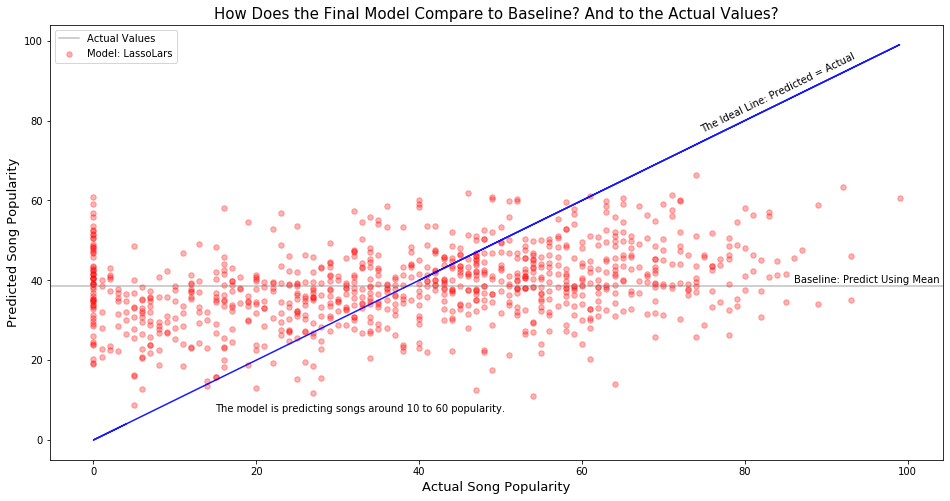

In [48]:
y_test, lars_pred_t


plt.figure(figsize=(16,8))
plt.axhline(baseline, alpha=.5, color="gray", label='Actual Values')
plt.annotate("Baseline: Predict Using Mean", (86, 39.5))

plt.plot(y_test, y_test, alpha=.9, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (74.5, 77), rotation=26)

plt.scatter(y_test, lars_pred_t, 
            alpha=.3, color='red', s=30, label="Model: LassoLars")


plt.legend()
plt.xlabel("Actual Song Popularity", size=13)
plt.ylabel("Predicted Song Popularity", size=13)
plt.title("How Does the Final Model Compare to Baseline? And to the Actual Values?", size=15)
plt.annotate("The model is predicting songs around 10 to 60 popularity.", (15, 7))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

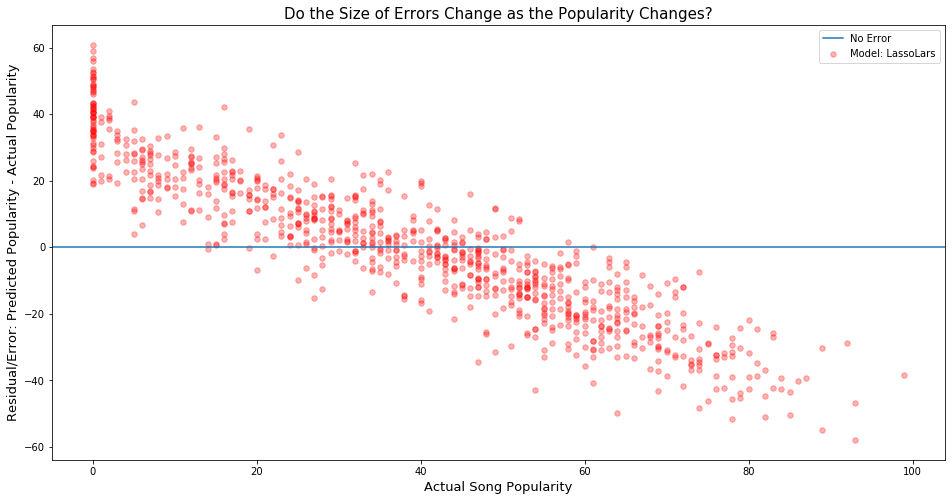

In [51]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_test, lars_pred_t - y_test, 
            alpha=.3, color='red', s=30, label="Model: LassoLars")

plt.legend()
plt.xlabel("Actual Song Popularity", size=13)
plt.ylabel("Residual/Error: Predicted Popularity - Actual Popularity", size=13)
plt.title("Do the Size of Errors Change as the Popularity Changes?", size=15)

plt.show()

In [40]:
model_performance

,train_rmse,validate_rmse,test_rmse
pf3_lr,18.796474,6.243039e+09,NaN
pf2_lr,20.526966,2.117323e+01,NaN
lassolars,21.104996,2.129290e+01,21.726116
ols,21.392088,NaN,NaN
baseline,22.822029,2.295860e+01,23.196285


Text(0.5, 0, 'Model Type')

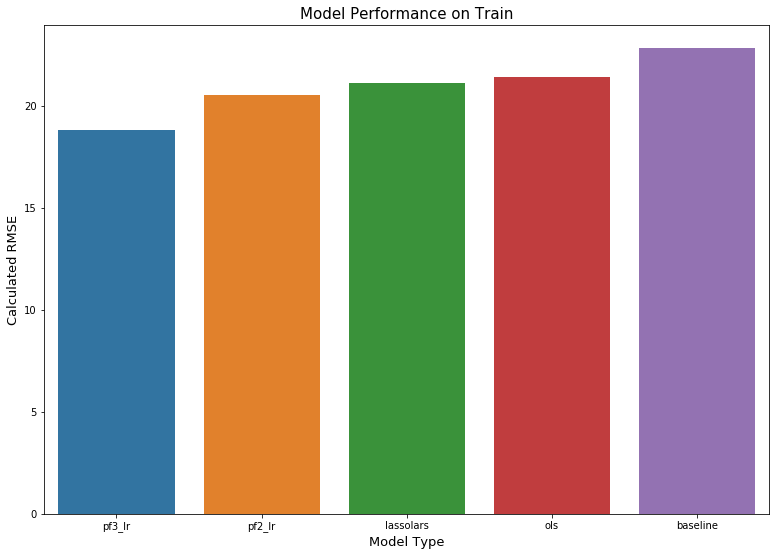

In [41]:
plt.figure(figsize=(13,9))
sns.barplot(model_performance.index, model_performance.train_rmse)
plt.title('Model Performance on Train', size = 15)
plt.ylabel('Calculated RMSE', size = 13)
plt.xlabel('Model Type', size = 13)

Text(0.5, 0, 'Model Type')

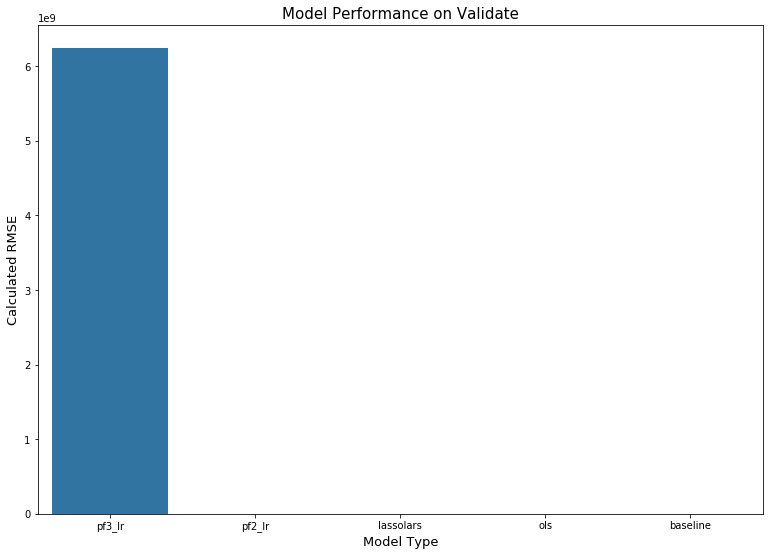

In [42]:
plt.figure(figsize=(13,9))
sns.barplot(model_performance.index, model_performance.validate_rmse)
plt.title('Model Performance on Validate', size = 15)
plt.ylabel('Calculated RMSE', size = 13)
plt.xlabel('Model Type', size = 13)

Text(0.5, 0, 'Model Type')

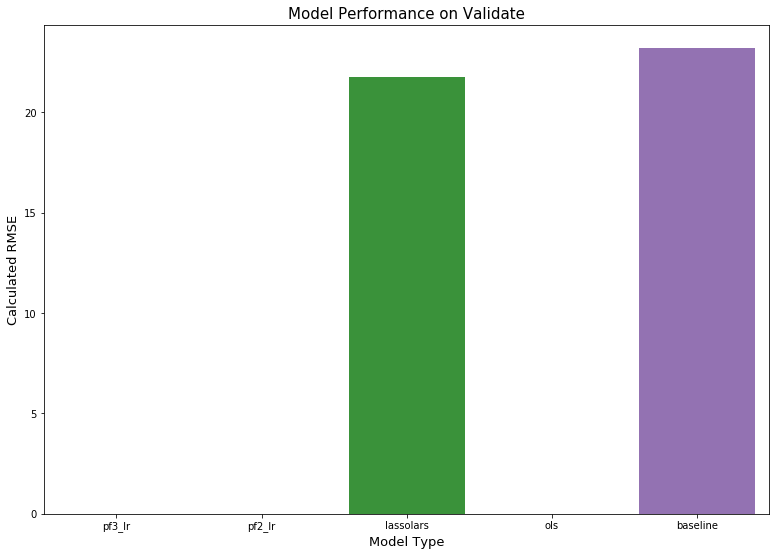

In [43]:
plt.figure(figsize=(13,9))
sns.barplot(model_performance.index, model_performance.test_rmse)
plt.title('Model Performance on Validate', size = 15)
plt.ylabel('Calculated RMSE', size = 13)
plt.xlabel('Model Type', size = 13)